In [15]:
import numpy as np
import scipy.io.wavfile as wav
from scipy import special
import matplotlib.pyplot as plt 
from IPython.display import IFrame
from IPython.core.display import display, HTML

In [22]:
IFrame("https://github.com/pedroamarocosta/CPSTP3/blob/master/trab_cps_3.pdf", width=985, height=1200)

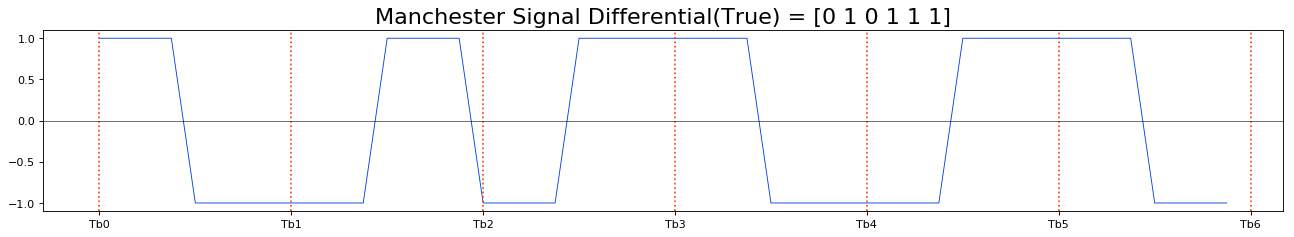

Wall time: 689 ms


In [16]:
%%time

def manchester_template(value, amp, points):
    
    p = int(points/2)
    codigo_linha = np.array([[-amp]*p, [amp]*p]).flatten()
 
    if(value == 1):
        return codigo_linha
    else:
        return codigo_linha*-1

def emissor_manchester(data, amp, points, diferential=False):
    
    signal = np.zeros(len(data) * points, dtype=int)
    val = data[0]

    for i in range(len(data)):
        
        if(diferential and i != 0):
            if(data[i] == 1):
                val = 1 if val == 0 else 0
        else:
            val = data[i]
        
        codigo = manchester_template(val, amp, points)
        signal[i * points: (i+1) * points] = codigo
            
    return signal.astype(int)

points = 8
amp = 1
λ = 0
differential = True
data = np.array([0, 1, 0, 1, 1, 1])

signal = emissor_manchester(data, amp, points, differential) 

x = np.arange(0,len(signal) + points, points)
x_label = ['Tb%i'%x for x in np.arange(0,(len(signal) / points)+1,1)]

display(HTML("<hr>"))
plt.figure(figsize=(20, 3), dpi = 80, facecolor = '1')
plt.title('Manchester Signal Differential('+str(differential) +') = ' + str(data), fontsize = 20)
plt.plot(signal, lw = '0.8', color = 'xkcd:blue')
plt.xticks(x, x_label)

for v_line in x: 
    plt.axvline(v_line, color='xkcd:red orange', ls='dotted')

#Recta do valor de decisão λ
plt.axhline( λ, xmin=0, xmax=1, color='xkcd:black', ls='solid', lw='0.5')

plt.show()

display(HTML("<p>" + str(signal) + "</p>"))
display(HTML("<br>"))



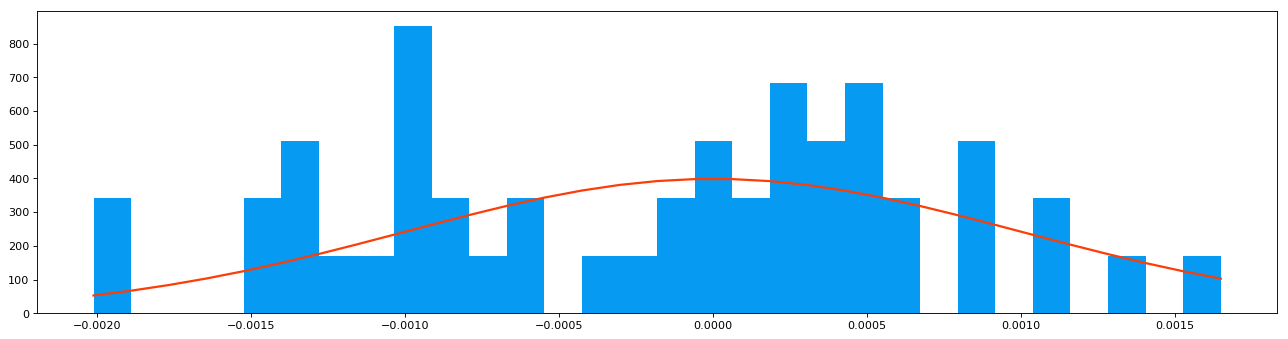

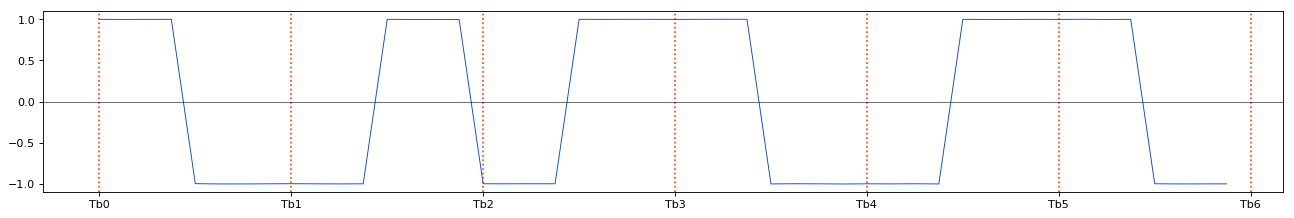

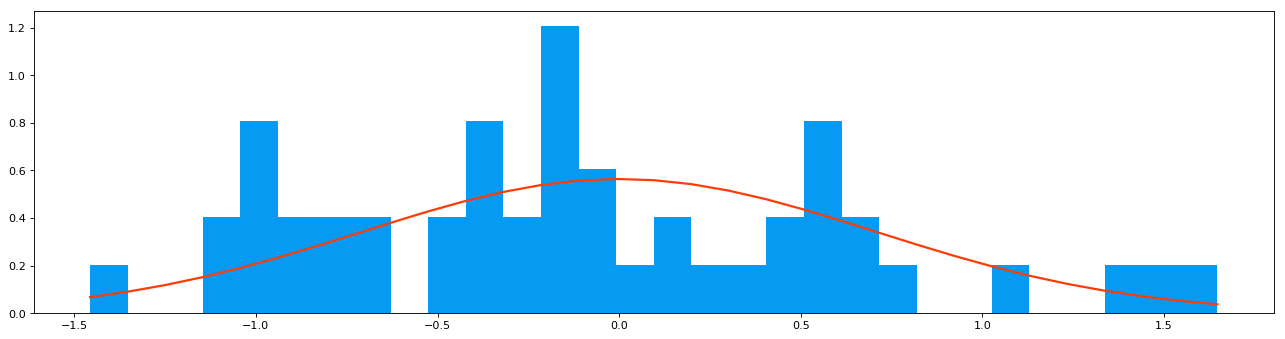

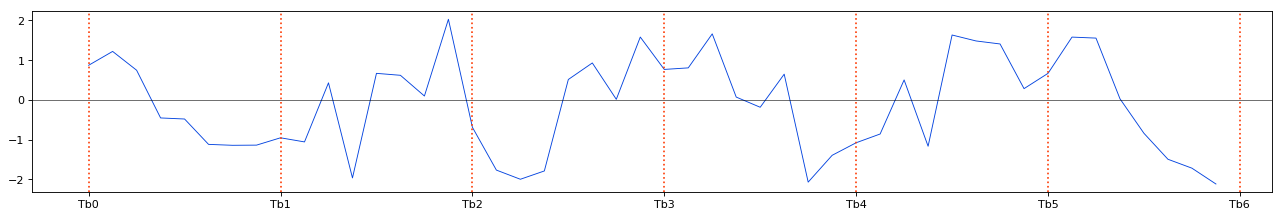

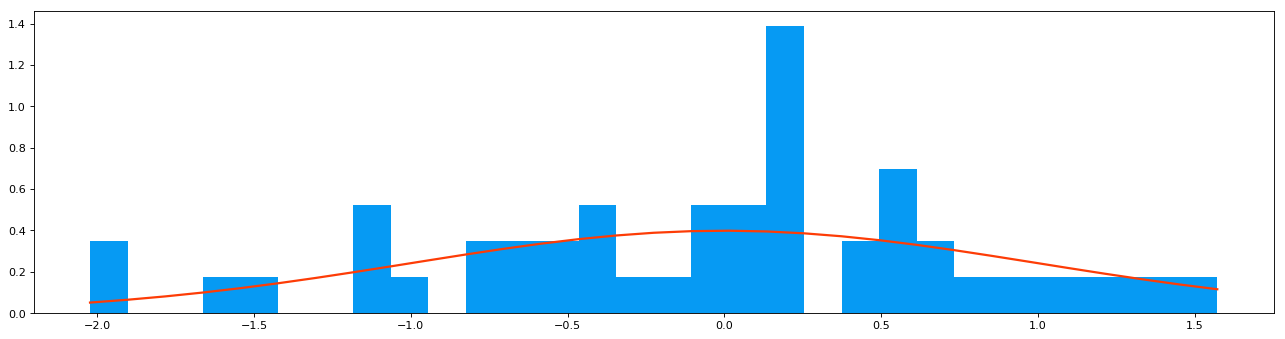

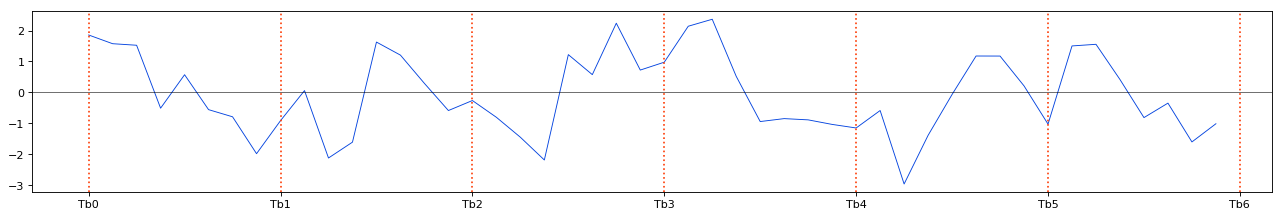

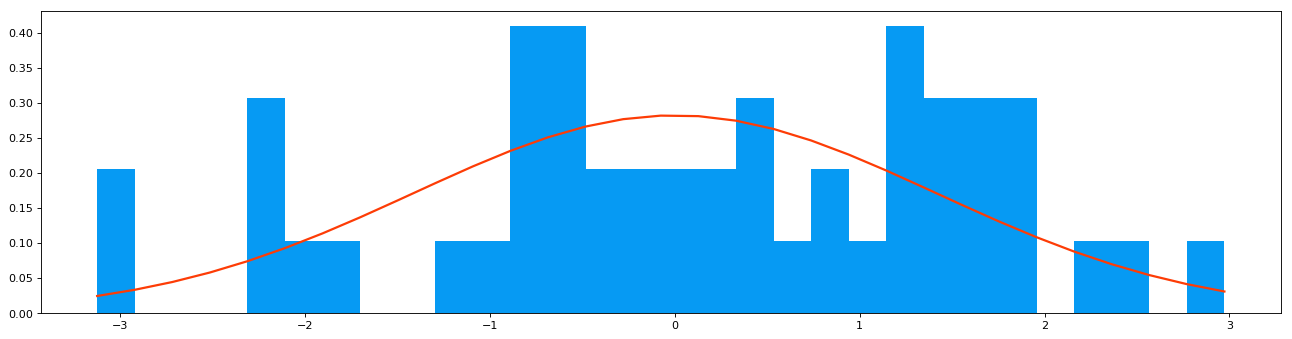

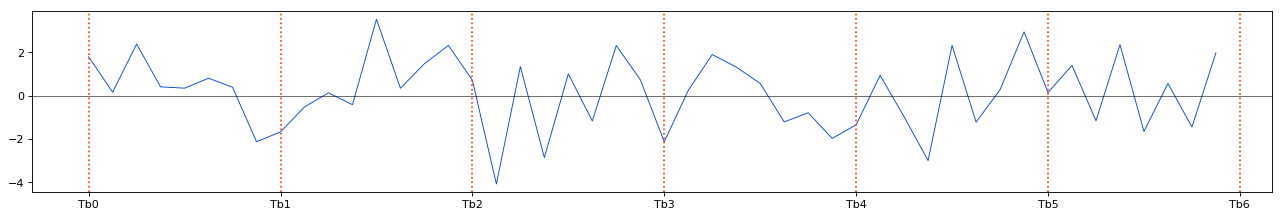

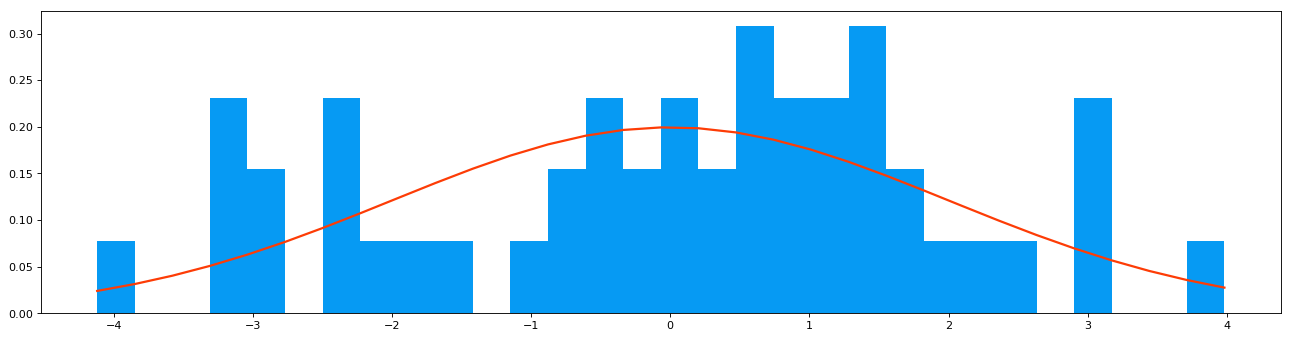

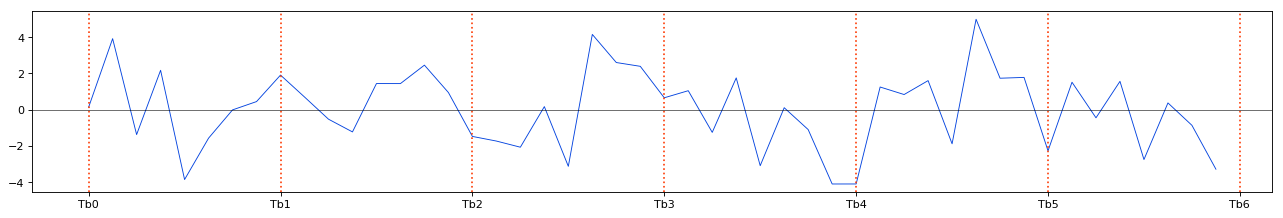

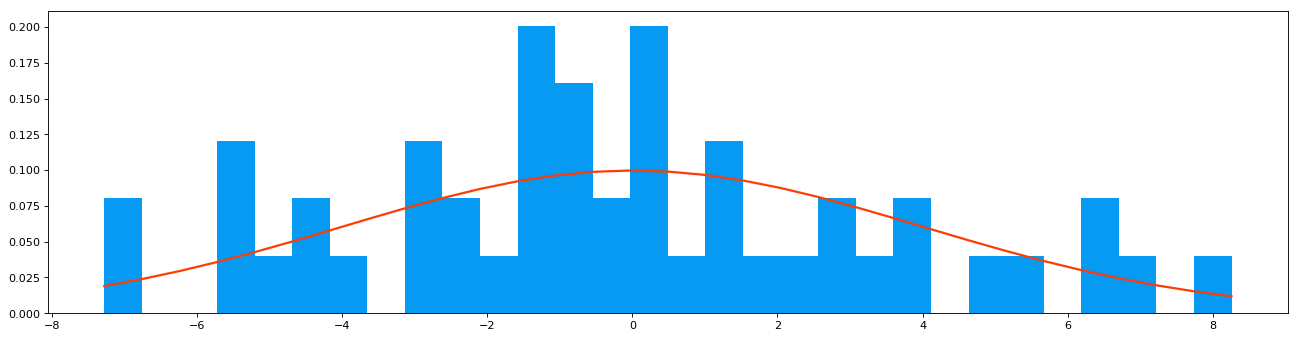

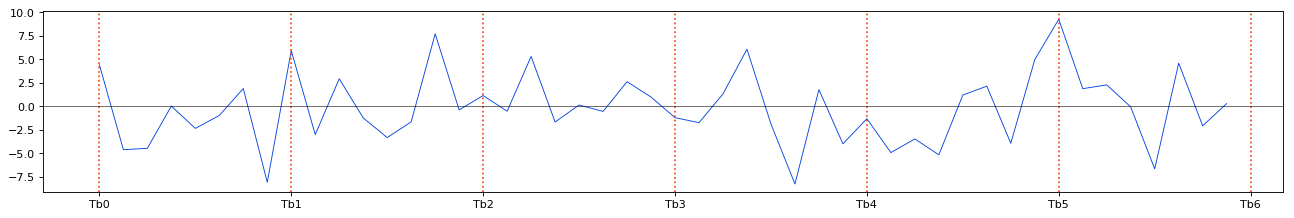

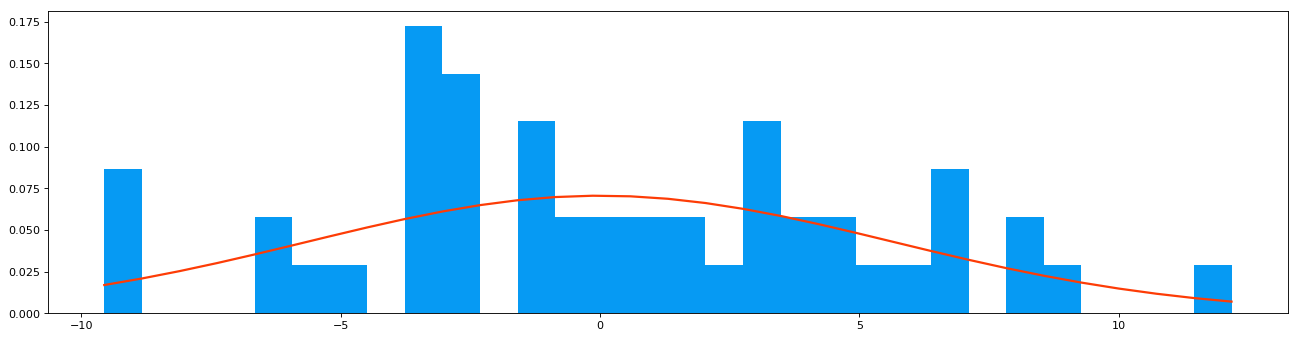

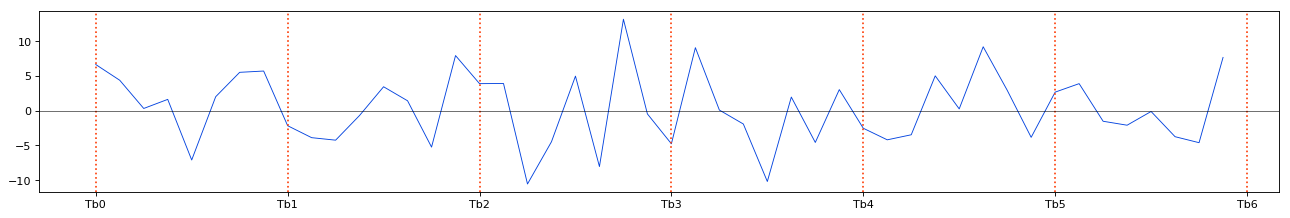

Wall time: 15.9 s


In [17]:
%%time

def add_AWGN(signal_without_noise, σ):
    
    Px = np.sum(signal_without_noise**2.0)/len(signal_without_noise)
    display(HTML('<h6>Sinal</h6>'))
    display(HTML('<p>Potencia Medida (dB) = ' + str(10 * np.log10(Px/2)) + '<br>' + 'Potencia Teórica (dB) = ' 
                 + str(10 * np.log10(amp**2)/2) + '</p>'))
    
    #Equação geradora de ruído
    noise = σ * np.random.randn(len(signal_without_noise))
    
    Peq = np.sum(noise**2.0)/len(noise)
    display(HTML('<h6>Ruído</h6>'))
    display(HTML('<p>Potencia Medida (dB) = ' + str(10 * np.log10(Peq)) + '<br>' + 'Potencia Teórica (dB) = ' 
                 + str(10 * np.log10(σ**2)) + '</p>'))
    
    plt.figure(figsize=(20, 5), dpi=80, facecolor='1')
    count, bins, ignored = plt.hist(noise, 30, histtype='barstacked', color='xkcd:azure', normed=True)
 
    #Função Normal
    normal_function =  (1/(σ * np.sqrt(2 * np.pi)) * np.exp( - (bins - 0)**2 / (2 * σ **2) ))
    
    plt.plot(bins, normal_function, lw=2, color='xkcd:red orange')
    
    signal = signal_without_noise + noise
    
    Px = np.sum(signal**2.0)/len(signal)
    display(HTML('<h6>Sinal com Ruído</h6>'))
    display(HTML('<p>Potencia Medida (dB) = ' + str(10 * np.log10(Px)) + '</p>'))
    
    return signal, noise



decision_value = λ = 0
mean = μ = 0 
variance_values = [0.000001, 0.5, 1, 2, 4, 16, 32]

signals_noise = [[0]]*len(variance_values)
awgn_noise = [[0]]*len(variance_values)

for i in range(len(variance_values)):
    
    standard_deviation = σ = np.sqrt(variance_values[i])

    display(HTML('<hr>'))
    display(HTML("<p>Com σ = " + '$\sqrt{' + str(variance_values[i]) + '}$' + ",</p>"))
    
    signals_noise[i], awgn_noise[i] = add_AWGN(signal, σ)
    
    x = np.arange(0,len(signals_noise[i])+points,points)
    x_label = ['Tb%i'%x for x in np.arange(0,(len(signals_noise[i])/points)+1,1)]
    
    plt.figure(figsize=(20, 3), dpi = 80, facecolor = '1')
    plt.plot(signals_noise[i], lw = '0.8', color = 'xkcd:blue')
    plt.xticks(x, x_label)
    
    for v_line in x: 
        plt.axvline(v_line, color='xkcd:red orange', ls='dotted')
    
    #Recta do valor de decisão λ
    plt.axhline( λ, xmin=0, xmax=1, color='xkcd:black', ls='solid', lw='0.5')
    
    display(HTML('<br>'))

    plt.show()

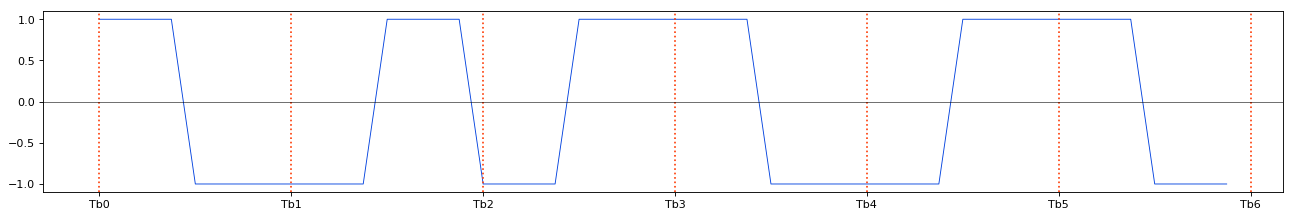

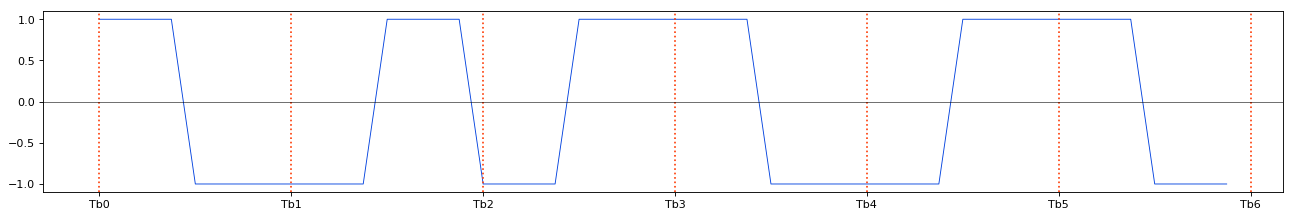

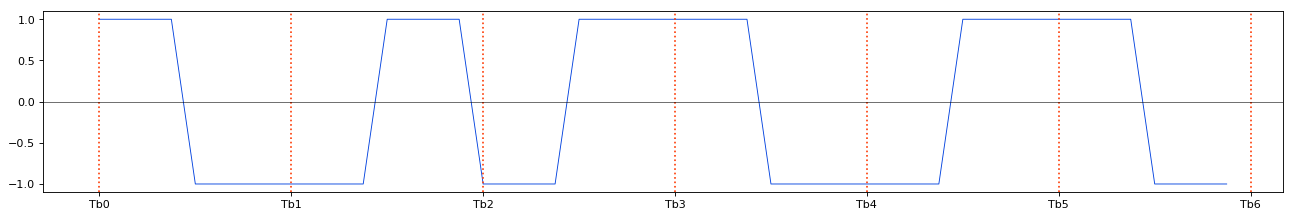

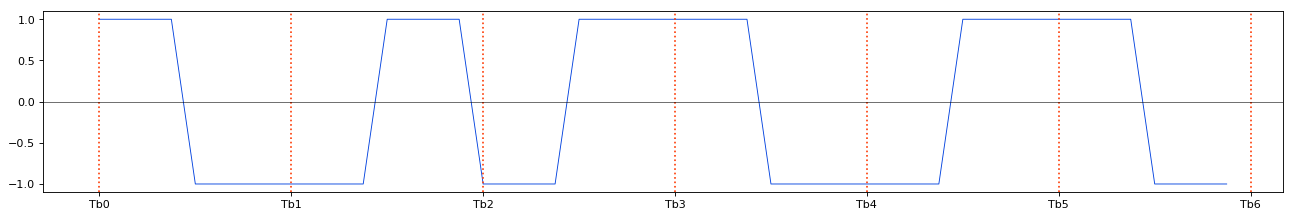

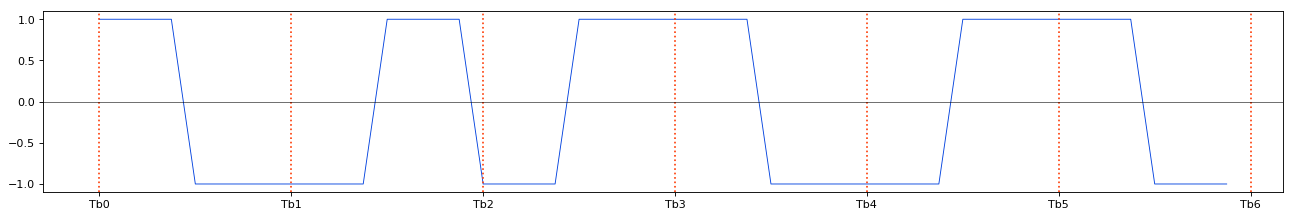

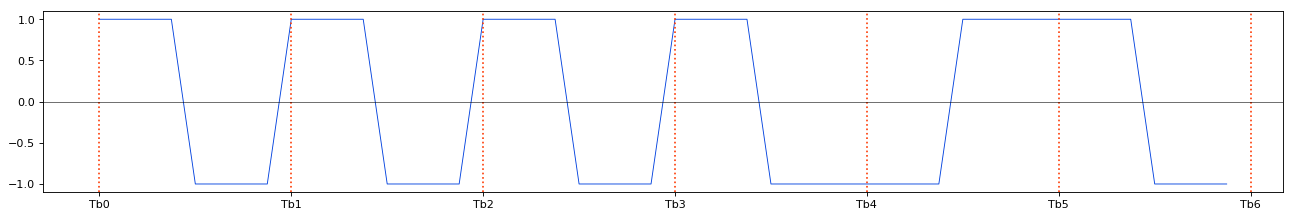

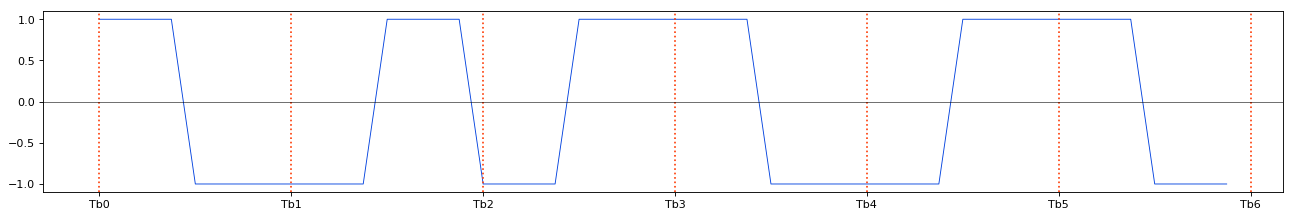

In [18]:
def adaptive_filter(signal_with_noise, amp, points):
    
    base = manchester_template(1, amp, points)
    filtered_signal = np.zeros(len(data) * points, dtype=int)
    num_slices = int(len(signal_with_noise)/points)
    
    for i in range(num_slices):
        signal_slice = signal_with_noise[i * points : (i + 1) * points]
        lam = np.dot(base, signal_slice)
        codigo = manchester_template(1 if lam>=0 else 0, amp, points)
        signal[i * points: (i+1) * points] = codigo

    return signal.astype(int)

filtered_signals = [[0]]*len(variance_values)

for i in range(len(signals_noise)):
    
    filtered_signal = adaptive_filter(signals_noise[i], amp, points)
    filtered_signals[i] = filtered_signal
    display(HTML('<hr>'))
    display(HTML("<p>Com valor de limiar de decisão (λ) = " + str(λ)  + " e com σ = $\sqrt{" 
                 + str(variance_values[i]) + '}$' + ",</p>"))
    
    x = np.arange(0,len(filtered_signal) + points, points)
    x_label = ['Tb%i'%x for x in np.arange(0,(len(filtered_signal) / points)+1,1)]

    plt.figure(figsize=(20, 3), dpi = 80, facecolor = '1')
    plt.plot(filtered_signal, lw = '0.8', color = 'xkcd:blue')
    plt.xticks(x, x_label)

    for v_line in x: 
        plt.axvline(v_line, color='xkcd:red orange', ls='dotted')

    #Recta do valor de decisão λ
    plt.axhline( λ, xmin=0, xmax=1, color='xkcd:black', ls='solid', lw='0.5')

    plt.show()


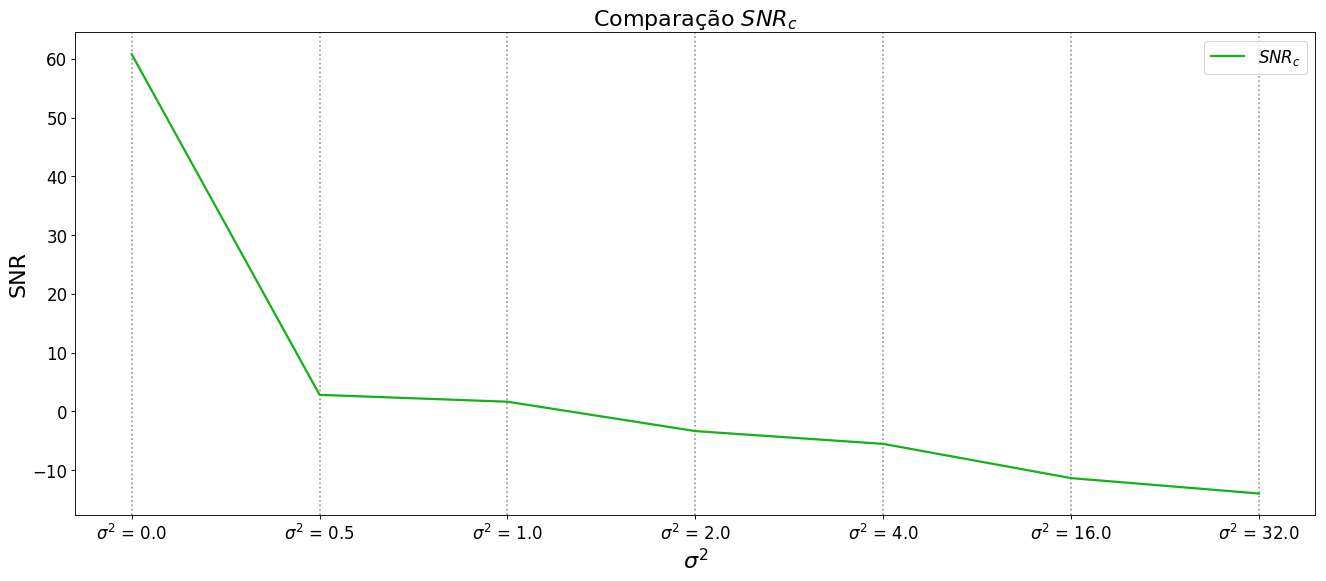

In [19]:
def calculate_SNR(signal, err_signal):
    
    Px = np.sum(signal**2.0)/len(signal)
    Perr = np.sum(err_signal**2.0)/len(err_signal)
    snrc = 10 * np.log10(Px / Perr)
    
    return snrc

array_snrc = [[0]]*len(variance_values)

for i in range(len(signals_noise)):
    
    snrc = calculate_SNR(signal, awgn_noise[i])
    array_snrc[i] = snrc
    display(HTML('<hr>'))
    display(HTML("<p>Com valor de limiar de decisão (λ) = " + str(λ)  
                 + " e com σ = $\sqrt{" + str(variance_values[i]) + '}$' + ",</p>"))
    display(HTML("<p>$SNR_c$ = " + str(array_snrc[i]) + " dB" + "</p>"))

plt.figure(figsize=(20, 8), dpi = 80, facecolor = '1')
x = np.arange(0,len(array_snrc) ,1)
x_label = ['${σ}^2$ = %.1f'%x for x in variance_values]
plt.xticks(x, x_label, fontsize=15)
plt.yticks(fontsize = 15)
for v_line in x: 
    plt.axvline(v_line, color='xkcd:gray', ls='dotted')

SNR_c, = plt.plot(array_snrc, lw = '2', color = 'xkcd:green')
plt.title('Comparação $SNR_c$', fontsize = 20)
plt.legend([SNR_c], ["$SNR_c$"], fontsize=15)
plt.ylabel('SNR', fontsize = 20)
plt.xlabel('${σ}^2$', fontsize = 20)
display(HTML('<hr>'))
plt.show()


Wall time: 498 µs


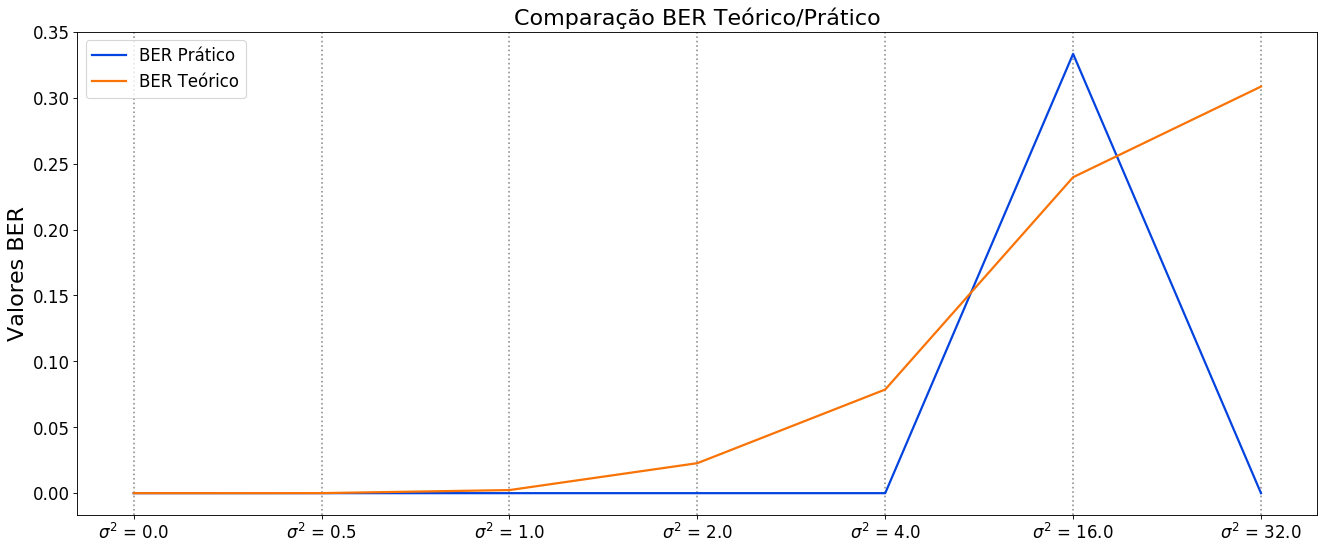

In [34]:
%time
def reverse_differential(data):
    
    new_data = np.zeros(len(data))
    new_data[0] = data[0]
    new_data[1:] = data[1:] ^ data[:len(data)-1]

    return new_data.astype(int)

def decoding_manchester(signal_without_noise, amp, points, differential = True):
    
    base = manchester_template(1, amp, points)
    num_slices = int(len(signal_without_noise)/points)
    data = np.zeros(num_slices)
    
    for i in range(num_slices):
        signal_slice = signal_without_noise[i * points : (i + 1) * points]
        lam = np.dot(base, signal_slice)
        data[i] = 1 if lam>=0 else 0
    
    if(differential):
        data = reverse_differential(data.astype(int))
    
    return data.astype(int)

retrieved_data = [[0]]*len(filtered_signals)
BER_praticos = [[0]]*len(filtered_signals)
BER_teoricos = [[0]]*len(filtered_signals)

plt.figure(figsize=(20, 8), dpi = 80, facecolor = '1')
    
for i in range(len(filtered_signals)):
    
    retrieved_data[i] = decoding_manchester(filtered_signals[i], amp, points, differential)

    num_of_errors = sum(data.astype(int) ^ retrieved_data[i].astype(int))
    BER_pratico = num_of_errors / len(data)
    BER_praticos[i] = BER_pratico
    
    BER_teorico = 0.5 * special.erfc(np.sqrt( ((amp**2)*points)/(2*(variance_values[i])) ))
    BER_teoricos[i] = BER_teorico
    display(HTML('<hr>'))
    display(HTML("<p>Com valor de limiar de decisão (λ) = " + str(λ)  
                 + " e com σ = $\sqrt{" + str(variance_values[i]) + '}$' + ",</p>"))
    display(HTML("<p>BER prático = " + str(BER_pratico) + "<br>" + "BER teórico = " + str(BER_teorico) + "</p>"))
    display(HTML("<p>Sinal Original    = " + str(data) + "<br>" + "Sinal Recebido = " + str(retrieved_data[i]) + "</p>"))
    

x = np.arange(0,len(variance_values) ,1)
x_label = ['${σ}^2$ = %.1f'%x for x in variance_values]
plt.xticks(x, x_label, fontsize=15)
plt.yticks(fontsize = 15)
for v_line in x: 
    plt.axvline(v_line, color='xkcd:gray', ls='dotted')

BER_p, = plt.plot(BER_praticos, lw = '2', color = 'xkcd:blue')
BER_t, = plt.plot(BER_teoricos, lw = '2', color = 'xkcd:orange')
plt.title('Comparação BER Teórico/Prático', fontsize = 20)
plt.legend([BER_p, BER_t],["BER Prático", "BER Teórico"], fontsize=15)
plt.ylabel('Valores BER', fontsize = 20)
display(HTML('<hr>'))
plt.show()
    

In [33]:
IFrame("https://github.com/pedroamarocosta/CPSTP3/blob/master/Resolu%C3%A7%C3%A3oExercicio7.png", width=985, height=1200)